In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

%matplotlib inline

In [4]:
E1 = np.load('B1957pol3_512g_2014-06-15T06:36:50.00000+536s.npy')

# Need to normalize by clean pulse avg - load pulse 3, get MP, IP averages
dc = np.load('B1957pol3_512g_2014-06-15T07:06:23.00000+536s.npy')

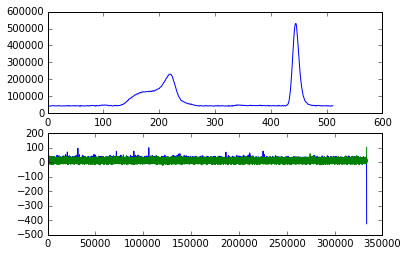

In [262]:
dbg = dc - np.median(dc, axis=1, keepdims=True)

#Use Victor's DM model instead...
prof = dbg.sum(0).sum(1)
peak = np.argmax(prof)

# Shift to max, sum MP, IP, windows
dbg = np.roll(dbg, 445-peak, axis=1)

MP = dbg[:, 430:460].sum(1)
MP = MP.reshape(MP.shape[0], MP.shape[-1]//2, 2).mean(-1)

IP = dbg[:, 200:250].sum(1)
IP = IP.reshape(IP.shape[0], IP.shape[-1]//2, 2).mean(-1)

MPmean = np.mean(MP[:-1], axis=0)
IPmean = np.mean(IP[:-1], axis=0)

plt.subplot(211)
plt.plot(dbg.sum(0).sum(-1))

plt.subplot(212)
plt.plot(MP.sum(-1))
plt.plot(IP.sum(-1))

(-2, 47)

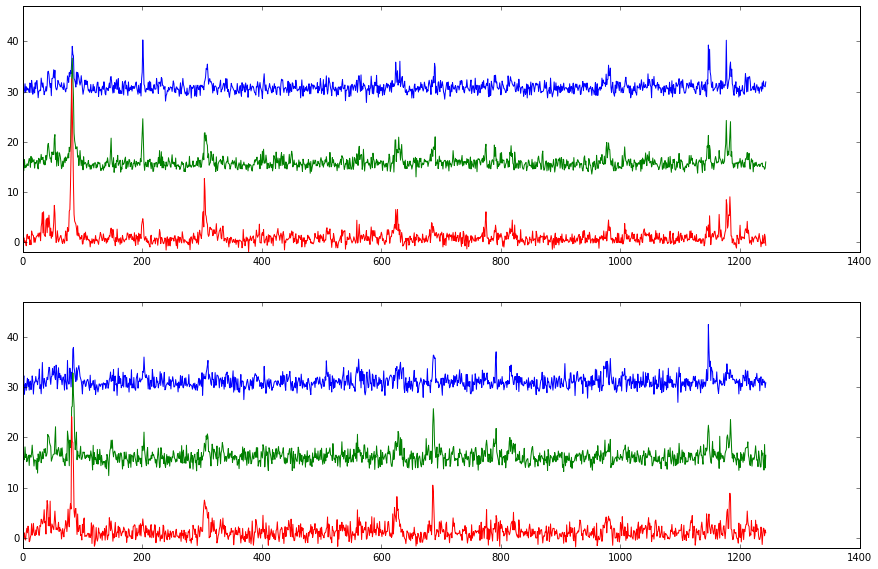

In [497]:
i = 30
d = E1[1244*i:1244*(i+1)]
poffset = np.array([0,15,30])

dbg = d - np.median(d, axis=1, keepdims=True)

#Use Victor's DM model instead...
prof = dbg.sum(0).sum(-1)
peak = np.argmax(prof)

# Shift to max, sum MP, IP, windows
dbg = np.roll(dbg, 445-peak, axis=1)

MP = dbg[:, 430:460].sum(1)

# Sum L, R in each IF
MP = MP.reshape(MP.shape[0], MP.shape[-1]//2, 2).mean(-1)
MP /= MPmean

IP = dbg[:, 200:250].sum(1)
IP = IP.reshape(IP.shape[0], IP.shape[-1]//2, 2).mean(-1)
IP /= IPmean

plt.figure(figsize=(15,15))

plt.subplot(311)
# ::-1 to reorder - lowest band is red, highest band is blue
plt.plot(MP[...,::-1]+poffset[np.newaxis, ::-1])

plt.ylim(-2,47)            

plt.subplot(312)
plt.plot(IP[...,::-1]+poffset[np.newaxis, ::-1])
plt.ylim(-2,47)


#plt.subplot(313)
#plt.plot(DM)
#plt.ylim(0, 0.0012)


In [6]:
E1.shape

(333478, 512, 6)

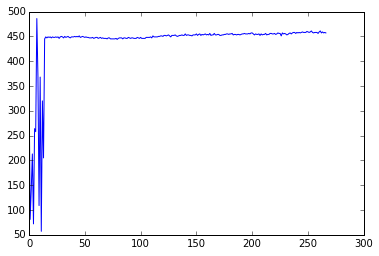

In [8]:
dbg = E1 - np.median(E1, axis=1, keepdims=True)
db = dbg[:267*1244].reshape(-1, 1244, 512, 6)
dmax = np.argmax(db[...,(0,1)].sum(-1).sum(1), axis=-1)

plt.plot(dmax)

(440, 460)

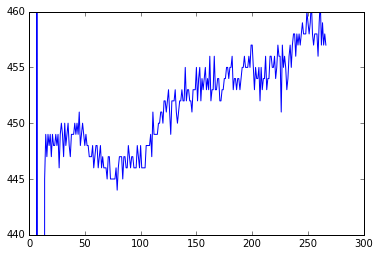

In [10]:
plt.plot(dmax)
plt.ylim(440,460)

In [14]:
import numpy as np
from scipy.signal import correlate
from scipy.optimize import curve_fit

def Gauss(x, *p):
    """
    Generic normal function used to fit the cross correlation peaks.
    """
    return np.exp(-(x - p[0])**2 / (2 * p[1]**2)) / (p[1] * np.sqrt(2 * np.pi))

def lin(x, *p):
    """
    Generic linear function for least squares fitting.
    """
    return (p[0] * x) + p[1]

def quad(x, *p):
    """
    Quadratic function in vertex form. Good to find extrema.
    """
    return (p[0] * (x - p[1])**2) + p[2]

# Load spectra
egr1 = np.array(E1)
ctl3 = np.array(dc)

# Sum LL and RR polarizations
egr1 = egr1.reshape(egr1.shape[0], egr1.shape[1], egr1.shape[-1]//2, 2).mean(-1)
ctl3 = ctl3.reshape(ctl3.shape[0], ctl3.shape[1], ctl3.shape[-1]//2, 2).mean(-1)

# Normalize pulse profiles with median
for i in range(egr1.shape[-1]):
    egr1[...,i] = egr1[...,i] / np.median(egr1[...,i]) - 1
    ctl3[...,i] = ctl3[...,i] / np.median(ctl3[...,i]) - 1

# Sum controls to get one high SNR pulse profile
ctl3 = np.sum(ctl3, axis=0)
m3 = np.argmax(ctl3.sum(-1))


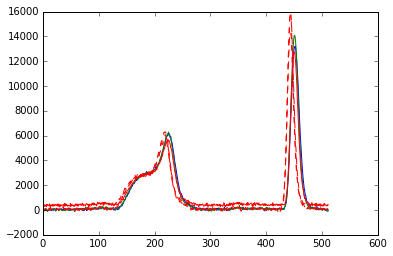

In [17]:
plt.plot(egr1.sum(0))
plt.plot(ctl3, 'r--')

#delays = []
#delay_errs = []

In [24]:
print "Using Victor's code to fit DMs"

# Compute time delays and their spread
egt1 = []
edt1 = []

# Fit lowest of three sub-bands
pol = 1

# bin by 1244 pulses, ~2 seconds
bin_factor=1244 // 2
egr1_binned = egr1[:267*1244].reshape(-1,bin_factor, 512, 3).sum(1)

i = 0
for d in egr1_binned[...,pol]:
    m = np.argmax(d[420:480]) + 420

    # Guess DM based on difference in profile peaks
    dm = m - m3
    
    # Offpulse noise for error
    sig = np.std(d[0:100])
    # Range of delays to fit chi-sq 
    dt = np.arange(dm-15, dm+15)
    chi = []
    pguess = [1., 1.]
    for i in dt:
        # Apply shift and fit
        shift = np.roll(ctl3[...,pol], i)
        popt, pcov = curve_fit(lin, shift, d, pguess, maxfev=1000)
        chi.append(np.sum((d - lin(shift, *popt))**2 / (sig**2)))
    
    pguess = [1., np.argmin(chi), chi[np.argmin(chi)]]
    try:
        popt, pcov = curve_fit(quad, dt, chi, pguess, maxfev=1000)
    except RuntimeError: # Eclipse will prevent a good fit
        egt1.append(0.)
        edt1.append(0.)
    else:
        if popt[0] > 0: # Sanity check that we have a good parabola
            egt1.append(popt[1])
            edt1.append(1./np.sqrt(np.abs(popt[0])))
        else:
            egt1.append(0.)
            edt1.append(0.)
    if i == 50:
        plt.plot(dt*1.6/1.024, chi, label=r"Computed value")
        plt.plot(dt*1.6/1.024, quad(dt, *popt), label="Quadratic fit")
        plt.legend(loc=2, prop={'size':24}, fancybox=1)
        plt.tick_params(labelsize=24)
        plt.title(r"Sample $\chi^2$ fit - {} band".format(fedge), \
                  size=36)
        plt.xlabel(r"Lag $[\mu s]$", size=30)
        plt.ylabel(r"$\chi^2_{red}$", size=30)
    i += 1
print "Finished fitting Egress 1"

egt1, edt1 = np.array(egt1), np.array(edt1)

# Convert time delays from phase to time
egt1 = egt1 * 1.6e3 / 1024.
edt1 = edt1 * 1.6e3 / 1024.

plt.figure(figsize=(15,10))

plt.plot(np.arange(len(egt1))*2, egt1)
plt.fill_between(np.arange(len(egt1))*2, egt1-edt1, egt1+edt1, alpha=0.5)

plt.ylim(-5,30)


Using Victor's code to fit DMs


/opt/python/2.7.9/lib/python2.7/site-packages/IPython/kernel/__main__.py:33: RuntimeWarning: divide by zero encountered in divide


ValueError: array must not contain infs or NaNs

In [18]:
curve_fit?